In [115]:
#pandas libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import sklearn.model_selection as modsel
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import statistics
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

%run "../notebooks/cargar_df.ipynb"

In [2]:
train = get_train()

In [3]:
test = get_test()

In [4]:
train = train[train.Stage.isin(['Closed Won', 'Closed Lost'])].copy()

# Me quedo con los registros con la oportunidad terminada
train.Stage.replace({'Closed Won': 1, 'Closed Lost': 0}, inplace=True)

# Junto el set de train y test en un nuevo data frame data
data = pd.concat([train.drop('Stage', axis=1), test])
data

grouped_data = data.groupby('Opportunity_ID').agg(\
    {'Region':'first',
     'Territory':'first',
     'Pricing, Delivery_Terms_Quote_Appr':'first',
     'Pricing, Delivery_Terms_Approved':'first',
     'Bureaucratic_Code_0_Approval':'first',
     'Bureaucratic_Code_0_Approved':'first',
     'Bureaucratic_Code':'first',
     'Account_Created_Date':'first',
     'Source ':'first',
     'Billing_Country':'first',
     'Account_Name':'first',
     'Opportunity_Name':'first',
     'Account_Owner':'first',
     'Opportunity_Owner':'first',
     'Account_Type':'first',
     'Opportunity_Type':'first',
     'Quote_Type':'first',
     'Delivery_Terms':'first',
     'Opportunity_Created_Date':'first',
     'Brand':'first',
     'Product_Type':'first',
     'Size':'first',
     'Product_Category_B':'first',
     'Price':'first',
     'Currency':'first',
     'Quote_Expiry_Date':'first',
     'Last_Modified_Date':'first',
     'Last_Modified_By':'first',
     'ASP_Currency':'first',
     'Total_Amount_Currency':'first',
     'Total_Taxable_Amount_Currency':'first',
     'Total_Taxable_Amount':'first'}).reset_index()
grouped_data

,Opportunity_ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency,Total_Taxable_Amount
0,0,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,None,...,None,None,None,1/30/2016,2016-06-13,Person_Name_18,EUR,EUR,EUR,5272800.0
1,1,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,None,...,None,None,None,1/20/2016,2016-01-15,Person_Name_20,EUR,EUR,EUR,48230.0
2,2,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,Source_7,...,None,None,None,9/30/2016,2016-09-29,Person_Name_8,USD,USD,USD,83865.6
3,3,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,Product_Category_B_16,0.42,USD,NaT,2018-03-27,Person_Name_8,USD,USD,USD,7421881.5
4,4,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,Product_Category_B_16,0.42,USD,6/2/2017,2018-03-27,Person_Name_8,USD,USD,USD,13357192.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,EMEA,Norway,1,1,0,0,Bureaucratic_Code_4,2013-07-27,Source_9,...,None,None,None,4/3/2016,2016-04-01,Person_Name_13,EUR,EUR,EUR,401700.0
11354,12800,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,None,None,None,1/15/2016,2016-10-10,Person_Name_13,USD,USD,USD,21332500.0
11355,12801,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,None,None,None,NaT,2016-01-19,Person_Name_13,EUR,EUR,EUR,299715.0
11356,12802,Americas,NE America,1,1,1,1,Bureaucratic_Code_4,2015-10-20,None,...,None,None,None,2/29/2016,2016-01-22,Person_Name_3,USD,USD,USD,0.0


### Agrego los features iniciales

In [82]:
X = pd.DataFrame({'Opportunity_ID':grouped_data.Opportunity_ID})

In [83]:
X['Pricing, Delivery_Terms_Quote_Appr'] = grouped_data['Pricing, Delivery_Terms_Quote_Appr']

X['Pricing, Delivery_Terms_Approved'] = grouped_data['Pricing, Delivery_Terms_Approved']

pricing_ok = grouped_data.agg(lambda x: int(x['Pricing, Delivery_Terms_Quote_Appr'] \
              == x['Pricing, Delivery_Terms_Approved']), axis = 1)
X['pricing_aprobada'] = pricing_ok


X['Bureaucratic_Code_0_Approval'] = grouped_data['Bureaucratic_Code_0_Approval']
X['Bureaucratic_Code_0_Approved'] = grouped_data['Bureaucratic_Code_0_Approved']

bureaucratic_ok = grouped_data.agg(lambda x: int(x['Bureaucratic_Code_0_Approval'] \
              == x['Bureaucratic_Code_0_Approved']), axis = 1)
X['bureaucratic_aprobada'] = bureaucratic_ok

ids = data.groupby('Opportunity_ID').ID.count()
group1 = (ids != 1).astype('int8').reset_index()
X['amount_ids'] = group1.ID


In [84]:
# Del archivo 'features_numericos'

# https://data.oecd.org/conversion/exchange-rates.htm
price_usd_convertion_by_year = {
    'EUR': {2016: 0.940, 2017: 0.923, 2018: 0.848, 2019: 0.893, 2020: 0.860},
    'JPY': {2016: 113.138, 2017: 116.667, 2018: 110.424, 2019: 109.008, 2020: 104.66},
    'AUD': {2016: 1.400, 2017: 1.358, 2018: 1.340, 2019: 1.439, 2020: 1.420},
    'GBP': {2016: 0.770, 2017: 0.808, 2018: 0.750, 2019: 0.784, 2020: 0.770},
    'USD': {2016: 1, 2017: 1, 2018: 1, 2019: 1, 2020: 1}
}

def get_convertion_usd(x):
    currency = x['Total_Amount_Currency']
    year = pd.to_datetime(x['Month']).year
    return price_usd_convertion_by_year[currency][year]
    
data['Total_Amount_Converted'] = data['Total_Amount'] / data.apply(lambda x: get_convertion_usd(x), axis=1)


data_prices = data.groupby('Opportunity_ID').agg(\
    {'Total_Amount_Converted':'mean'}).reset_index()


X['Total_Amount_Converted_mean'] = data_prices['Total_Amount_Converted'].fillna(\
                                   data_prices['Total_Amount_Converted'].mean())

In [85]:
# Del archivo 'features_fechas'

df_fechas_train = pd.read_csv('../files_csv/features_fechas_train.csv')
df_fechas_test = pd.read_csv('../files_csv/features_fechas_test.csv')
df_fechas = pd.concat([df_fechas_train,df_fechas_test])
df_fechas

,Opportunity_ID,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days
0,0,189,54.0,60.0,320,146
1,1,39,44.0,2.0,216,42
2,2,296,297.0,0.0,279,48
3,3,840,52.0,58.0,1650,786
4,4,840,542.0,27.0,1650,786
...,...,...,...,...,...,...
1562,12364,0,28.0,9.0,688,5
1563,12365,1,28.0,91.0,480,158
1564,12366,1,28.0,91.0,480,158
1565,12367,0,30.0,0.0,337,97


In [86]:
X = X.merge(df_fechas, on='Opportunity_ID')

In [87]:
X

,Opportunity_ID,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",pricing_aprobada,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,bureaucratic_aprobada,amount_ids,Total_Amount_Converted_mean,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days
0,0,1,1,1,1,1,1,0,5.609362e+06,189,54.0,60.0,320,146
1,1,0,0,1,0,0,1,0,5.130851e+04,39,44.0,2.0,216,42
2,2,0,0,1,0,0,1,0,8.386560e+04,296,297.0,0.0,279,48
3,3,1,0,0,1,0,0,0,7.421882e+06,840,52.0,58.0,1650,786
4,4,1,0,0,1,0,0,0,1.335719e+07,840,542.0,27.0,1650,786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,1,1,1,0,0,1,0,4.273404e+05,119,121.0,20.0,979,119
11354,12800,1,0,0,0,0,1,1,1.066625e+07,311,42.0,88.0,840,304
11355,12801,1,1,1,1,1,1,1,1.062819e+05,46,52.0,4.0,66,108
11356,12802,1,1,1,1,1,1,0,2.346797e+06,48,86.0,4.0,188,142


In [25]:
# Del archivo 'features categorical'

df_mean_train = pd.read_csv('../files_csv/train_mean_days.csv')
df_mean_test = pd.read_csv('../files_csv/test_mean_days.csv')
df_mean_enc = pd.concat([df_mean_train, df_mean_test]).drop('Unnamed: 0', axis=1)
df_mean_enc

,Opportunity_ID,Region_days,Region_amount,Bureaucratic_Code_days,Bureaucratic_Code_amount,Delivery_Terms_days,Delivery_Terms_amount,Opportunity_Type_days,Opportunity_Type_amount,Account_Type_days,Account_Type_amount,Last_Modified_By_days,Last_Modified_By_amount,Opportunity_Owner_days,Opportunity_Owner_amount,Source _days,Source _amount
0,0,83.432141,1.226018e+06,68.886894,8.633106e+05,78.841211,1.007210e+06,87.724601,5.946322e+05,88.799743,1.026040e+06,66.275000,7.587761e+05,63.555698,1.121455e+06,89.632200,1.120594e+06
1,1,83.432141,1.226018e+06,68.886894,8.633106e+05,78.841211,1.007210e+06,87.724601,5.946322e+05,88.799743,1.026040e+06,123.318182,1.327410e+05,78.380952,2.675057e+05,89.632200,1.120594e+06
2,2,98.205086,1.555565e+06,68.886894,8.633106e+05,90.183708,1.052486e+06,87.724601,5.946322e+05,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,98.953715,1.401714e+06
3,3,98.205086,1.555565e+06,151.909091,2.220317e+06,104.112874,1.758935e+06,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
4,4,98.205086,1.555565e+06,151.909091,2.220317e+06,104.112874,1.758935e+06,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,88.128370,1.252214e+06,68.886894,8.633106e+05,104.112874,1.758935e+06,51.850510,4.368914e+05,56.705531,5.673916e+05,65.600805,1.039749e+06,37.729927,9.746688e+04,76.746954,8.309697e+05
1563,12365,88.128370,1.252214e+06,68.886894,8.633106e+05,104.112874,1.758935e+06,51.850510,4.368914e+05,56.705531,5.673916e+05,65.600805,1.039749e+06,37.729927,9.746688e+04,76.746954,8.309697e+05
1564,12366,88.128370,1.252214e+06,68.886894,8.633106e+05,104.112874,1.758935e+06,87.724601,5.946322e+05,88.799743,1.026040e+06,65.600805,1.039749e+06,78.914980,1.081317e+06,109.852941,2.288249e+05
1565,12367,83.432141,1.226018e+06,68.886894,8.633106e+05,78.841211,1.007210e+06,87.724601,5.946322e+05,88.799743,1.026040e+06,65.600805,1.039749e+06,66.692884,6.491445e+05,98.953715,1.401714e+06


In [88]:
# Del archivo 'features categorical'

df_bin_train = pd.read_csv('../files_csv/train_binary_enc_7_cols.csv')
df_bin_test = pd.read_csv('../files_csv/test_binary_enc_7_cols.csv')
df_bin_enc = pd.concat([df_bin_train, df_bin_test])
df_bin_enc

,Opportunity_ID,Region_1,Region_2,Region_3,Territory_1,Territory_2,Territory_3,Territory_4,Territory_5,Territory_6,...,Account_Type_1,Account_Type_2,Account_Type_3,Billing_Country_1,Billing_Country_2,Billing_Country_3,Billing_Country_4,Billing_Country_5,Billing_Country_6,Billing_Country_7
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,2,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,3,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,4,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,0,0,1,0,1,0,0,0,1,...,0,1,1,0,1,0,1,1,0,1
1563,12365,0,1,0,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1564,12366,0,1,0,0,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1565,12367,0,1,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0


In [75]:
# Del archivo 'features categorical'

df_target_train = pd.read_csv('../files_csv/train_target_enc_7_cols.csv')
df_target_test = pd.read_csv('../files_csv/test_target_enc_7_cols.csv')
df_target_enc = pd.concat([df_target_train, df_target_test])
df_target_enc

,Opportunity_ID,Source,Opportunity_Owner,Delivery_Terms,Opportunity_Type,Account_Name,Last_Modified_By
0,0,0.513541,0.482405,0.479801,0.520281,0.518027,0.381579
1,1,0.513541,0.518027,0.479801,0.520281,0.518027,0.518027
2,2,0.440136,0.562254,0.547011,0.520281,0.822785,0.437984
3,3,0.632822,0.562254,0.449874,0.158183,0.518027,0.437984
4,4,0.632822,0.562254,0.449874,0.158183,0.518027,0.437984
...,...,...,...,...,...,...,...
1562,12364,0.526490,0.574074,0.518027,0.520281,0.518027,0.521978
1563,12365,0.513541,0.349693,0.547011,0.520281,0.518027,0.333333
1564,12366,0.513541,0.349693,0.547011,0.520281,0.518027,0.333333
1565,12367,0.513541,0.518027,0.547011,0.688221,0.518027,0.518027


In [31]:
# Del archivo 'features categorical'

df_cat_train = pd.read_csv('../files_csv/train_cat_enc_26_cols.csv')
df_cat_test = pd.read_csv('../files_csv/test_cat_enc_26_cols.csv')
df_cat_enc = pd.concat([df_cat_train, df_cat_test])
df_cat_enc

,Opportunity_ID,Region,Territory,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Account_Name,Opportunity_Name,...,Product_Type,Size,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency
0,0,0.504556,0.618947,0.415276,0.436083,0.588886,0.475482,0.479551,0.551375,0.452898,...,0.563817,0.604471,0.494060,0.618610,0.522716,0.132937,0.316337,0.445631,0.583160,0.542879
1,1,0.523115,0.521325,0.604962,0.464447,0.585918,0.509219,0.594602,0.520764,0.497335,...,0.554836,0.628808,0.496615,0.504029,0.545301,0.541291,0.672297,0.472581,0.390932,0.441528
2,2,0.468367,0.713799,0.454188,0.423713,0.539575,0.459604,0.536891,0.807842,0.496299,...,0.496769,0.566104,0.467738,0.504514,0.556729,0.887222,0.462798,0.492280,0.466973,0.422812
3,3,0.407498,0.587917,0.394974,0.492367,0.228532,0.637074,0.433497,0.254328,0.469851,...,0.037384,0.017035,0.179622,0.549715,0.011188,0.322723,0.377569,0.511753,0.541772,0.471926
4,4,0.499265,0.622668,0.330164,0.480089,0.242223,0.643448,0.569161,0.131504,0.486388,...,0.018939,0.008988,0.086680,0.125472,0.004865,0.668401,0.494510,0.452361,0.426220,0.481163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,12364,0.463409,0.424464,0.625895,0.533608,0.595665,0.526462,0.543169,0.592548,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.521967,0.463713,0.463713,0.464785
1563,12365,0.446196,0.368397,0.625895,0.533608,0.595665,0.513542,0.452013,0.379507,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.335972,0.463713,0.463713,0.464785
1564,12366,0.446196,0.368397,0.409606,0.487453,0.595665,0.513542,0.452013,0.379507,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.335972,0.463713,0.463713,0.464785
1565,12367,0.446196,0.347819,0.625895,0.533608,0.595665,0.513542,0.452013,0.518027,0.518027,...,0.555102,0.554131,0.555223,0.553527,0.550463,0.518027,0.518027,0.463713,0.463713,0.464785


### Busco la mejor combinacion de features para predecir

In [151]:
# Calculo el error
def calcular_error_xgboost(df):
    kf = KFold(n_splits=5, shuffle=True)

    errores = []
    for train_index, test_index in kf.split(df):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        xgb_reg = xgb.XGBRegressor(objective = 'binary:logistic', \
                               eval_metric='logloss')
        xgb_reg.fit(X_train, y_train)
        preds = xgb_reg.predict(X_test)

        loss = log_loss(y_test, preds)
        errores.append(loss)
    
    print("Log loss: %f" % (statistics.mean(errores)))
    

def importancia_features_xgboost(df):
    xgb_reg = xgb.XGBRegressor(objective = 'binary:logistic', \
                               eval_metric='logloss')
    xgb_reg.fit(df, y)
    
    p = pd.DataFrame({'feature':df.columns, 'value':xgb_reg.feature_importances_})
    g = p.sort_values('value')

    plt.bar(g.feature, g.value, )
    plt.xlabel('Features')
    plt.xticks(rotation=90)
    plt.ylabel('Importancia')
    plt.title('Importancia Features con XGBRegressor')
    plt.show()

In [89]:
X['Bureaucratic_Code_0_Approval'] = X['Bureaucratic_Code_0_Approval'].astype('int8')
X['Bureaucratic_Code_0_Approved'] = X['Bureaucratic_Code_0_Approved'].astype('int8')

In [90]:
train_ids = train.Opportunity_ID.unique()
trainX = X[X['Opportunity_ID'].isin(train_ids)]

y = train.groupby('Opportunity_ID')['Stage'].min()

test_ids = test.Opportunity_ID.unique()
testX = X[X['Opportunity_ID'].isin(test_ids)]

df_train = trainX.drop('Opportunity_ID', axis=1).copy()

In [91]:
calcular_error_xgboost(trainX)

Log loss: 0.622784


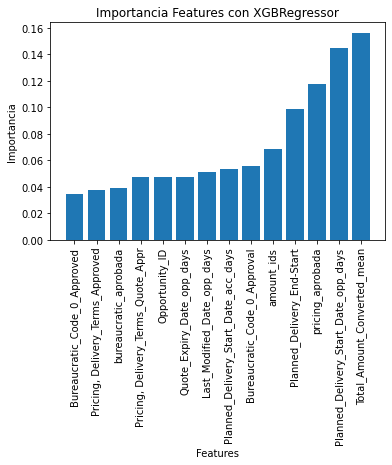

In [92]:
importancia_features_xgboost(trainX)

In [93]:
X_mean = X.merge(df_mean_enc, on='Opportunity_ID')
X_mean

,Opportunity_ID,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",pricing_aprobada,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,bureaucratic_aprobada,amount_ids,Total_Amount_Converted_mean,Last_Modified_Date_opp_days,...,Opportunity_Type_days,Opportunity_Type_amount,Account_Type_days,Account_Type_amount,Last_Modified_By_days,Last_Modified_By_amount,Opportunity_Owner_days,Opportunity_Owner_amount,Source _days,Source _amount
0,0,1,1,1,1,1,1,0,5.609362e+06,189,...,87.724601,5.946322e+05,88.799743,1.026040e+06,66.275000,7.587761e+05,63.555698,1.121455e+06,89.632200,1.120594e+06
1,1,0,0,1,0,0,1,0,5.130851e+04,39,...,87.724601,5.946322e+05,88.799743,1.026040e+06,123.318182,1.327410e+05,78.380952,2.675057e+05,89.632200,1.120594e+06
2,2,0,0,1,0,0,1,0,8.386560e+04,296,...,87.724601,5.946322e+05,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,98.953715,1.401714e+06
3,3,1,0,0,1,0,0,0,7.421882e+06,840,...,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
4,4,1,0,0,1,0,0,0,1.335719e+07,840,...,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,1,1,1,0,0,1,0,4.273404e+05,119,...,50.325591,4.849739e+05,88.799743,1.026040e+06,68.591667,1.088591e+06,85.040909,1.155765e+06,98.953715,1.401714e+06
11354,12800,1,0,0,0,0,1,1,1.066625e+07,311,...,87.724601,5.946322e+05,88.799743,1.026040e+06,91.037313,2.137204e+06,93.386179,1.482360e+06,86.633028,9.328264e+05
11355,12801,1,1,1,1,1,1,1,1.062819e+05,46,...,50.325591,4.849739e+05,56.705531,5.673916e+05,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
11356,12802,1,1,1,1,1,1,0,2.346797e+06,48,...,50.325591,4.849739e+05,56.705531,5.673916e+05,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06


In [94]:
train_ids = train.Opportunity_ID.unique()
trainX = X_mean[X_mean['Opportunity_ID'].isin(train_ids)].copy()
trainX.drop('Opportunity_ID', axis=1, inplace=True)

test_ids = test.Opportunity_ID.unique()
testX = X_mean[X_mean['Opportunity_ID'].isin(test_ids)].copy()
testX.drop('Opportunity_ID', axis=1, inplace=True)

In [95]:
calcular_error_xgboost(trainX)

Log loss: 0.587138


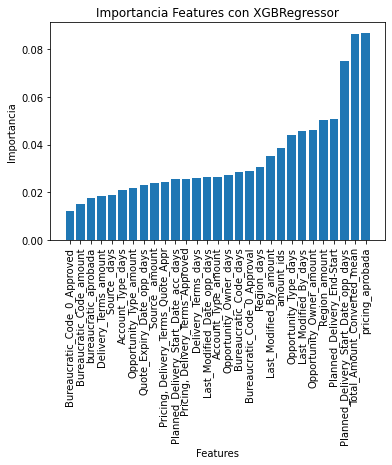

In [96]:
importancia_features_xgboost(trainX)

In [97]:
X_target = X.merge(df_target_enc, on='Opportunity_ID')
X_target

,Opportunity_ID,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",pricing_aprobada,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,bureaucratic_aprobada,amount_ids,Total_Amount_Converted_mean,Last_Modified_Date_opp_days,Quote_Expiry_Date_opp_days,Planned_Delivery_End-Start,Planned_Delivery_Start_Date_acc_days,Planned_Delivery_Start_Date_opp_days,Source,Opportunity_Owner,Delivery_Terms,Opportunity_Type,Account_Name,Last_Modified_By
0,0,1,1,1,1,1,1,0,5.609362e+06,189,54.0,60.0,320,146,0.513541,0.482405,0.479801,0.520281,0.518027,0.381579
1,1,0,0,1,0,0,1,0,5.130851e+04,39,44.0,2.0,216,42,0.513541,0.518027,0.479801,0.520281,0.518027,0.518027
2,2,0,0,1,0,0,1,0,8.386560e+04,296,297.0,0.0,279,48,0.440136,0.562254,0.547011,0.520281,0.822785,0.437984
3,3,1,0,0,1,0,0,0,7.421882e+06,840,52.0,58.0,1650,786,0.632822,0.562254,0.449874,0.158183,0.518027,0.437984
4,4,1,0,0,1,0,0,0,1.335719e+07,840,542.0,27.0,1650,786,0.632822,0.562254,0.449874,0.158183,0.518027,0.437984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,1,1,1,0,0,1,0,4.273404e+05,119,121.0,20.0,979,119,0.557979,0.574074,0.479801,0.520281,0.587571,0.521978
11354,12800,1,0,0,0,0,1,1,1.066625e+07,311,42.0,88.0,840,304,0.513541,0.574074,0.547011,0.158183,0.518027,0.521978
11355,12801,1,1,1,1,1,1,1,1.062819e+05,46,52.0,4.0,66,108,0.440136,0.574074,0.479801,0.520281,0.518027,0.521978
11356,12802,1,1,1,1,1,1,0,2.346797e+06,48,86.0,4.0,188,142,0.513541,0.285467,0.547011,0.520281,0.518027,0.152344


In [98]:
trainX = X_target[X_target['Opportunity_ID'].isin(train_ids)].copy()
trainX.drop('Opportunity_ID', axis=1, inplace=True)

testX = X_target[X_target['Opportunity_ID'].isin(test_ids)].copy()
testX.drop('Opportunity_ID', axis=1, inplace=True)

In [99]:
calcular_error_xgboost(trainX)

Log loss: 0.589782


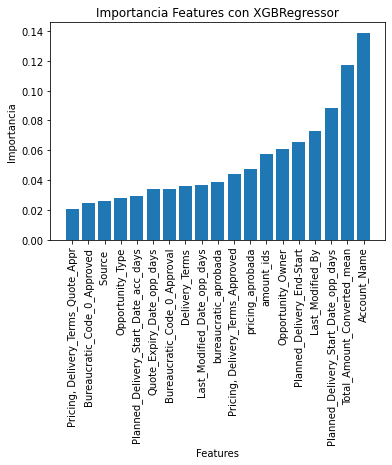

In [100]:
importancia_features_xgboost(trainX)

In [101]:
X_bin = X.merge(df_bin_enc, on='Opportunity_ID')
X_bin

,Opportunity_ID,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",pricing_aprobada,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,bureaucratic_aprobada,amount_ids,Total_Amount_Converted_mean,Last_Modified_Date_opp_days,...,Account_Type_1,Account_Type_2,Account_Type_3,Billing_Country_1,Billing_Country_2,Billing_Country_3,Billing_Country_4,Billing_Country_5,Billing_Country_6,Billing_Country_7
0,0,1,1,1,1,1,1,0,5.609362e+06,189,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,1,0,0,1,0,5.130851e+04,39,...,0,0,1,0,0,0,0,0,0,1
2,2,0,0,1,0,0,1,0,8.386560e+04,296,...,0,1,0,0,0,0,0,0,1,0
3,3,1,0,0,1,0,0,0,7.421882e+06,840,...,0,1,0,0,0,0,0,0,1,0
4,4,1,0,0,1,0,0,0,1.335719e+07,840,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,1,1,1,0,0,1,0,4.273404e+05,119,...,0,1,1,0,0,0,0,1,1,1
11354,12800,1,0,0,0,0,1,1,1.066625e+07,311,...,0,1,0,0,0,0,0,1,1,1
11355,12801,1,1,1,1,1,1,1,1.062819e+05,46,...,0,1,0,0,0,0,1,1,0,0
11356,12802,1,1,1,1,1,1,0,2.346797e+06,48,...,0,1,0,0,0,0,0,0,1,0


In [102]:
trainX = X_bin[X_bin['Opportunity_ID'].isin(train_ids)].copy()
trainX.drop('Opportunity_ID', axis=1, inplace=True)

testX = X_bin[X_bin['Opportunity_ID'].isin(test_ids)].copy()
testX.drop('Opportunity_ID', axis=1, inplace=True)

In [103]:
calcular_error_xgboost(trainX)

Log loss: 0.611662


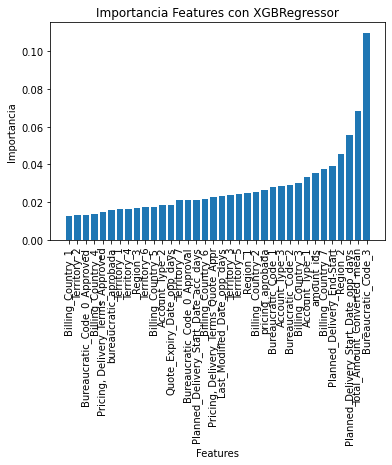

In [104]:
importancia_features_xgboost(trainX)

In [105]:
X_cat = X.merge(df_cat_enc, on='Opportunity_ID')
X_cat

,Opportunity_ID,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",pricing_aprobada,Bureaucratic_Code_0_Approval_x,Bureaucratic_Code_0_Approved_x,bureaucratic_aprobada,amount_ids,Total_Amount_Converted_mean,Last_Modified_Date_opp_days,...,Product_Type,Size,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_By,ASP_Currency,Total_Amount_Currency,Total_Taxable_Amount_Currency
0,0,1,1,1,1,1,1,0,5.609362e+06,189,...,0.563817,0.604471,0.494060,0.618610,0.522716,0.132937,0.316337,0.445631,0.583160,0.542879
1,1,0,0,1,0,0,1,0,5.130851e+04,39,...,0.554836,0.628808,0.496615,0.504029,0.545301,0.541291,0.672297,0.472581,0.390932,0.441528
2,2,0,0,1,0,0,1,0,8.386560e+04,296,...,0.496769,0.566104,0.467738,0.504514,0.556729,0.887222,0.462798,0.492280,0.466973,0.422812
3,3,1,0,0,1,0,0,0,7.421882e+06,840,...,0.037384,0.017035,0.179622,0.549715,0.011188,0.322723,0.377569,0.511753,0.541772,0.471926
4,4,1,0,0,1,0,0,0,1.335719e+07,840,...,0.018939,0.008988,0.086680,0.125472,0.004865,0.668401,0.494510,0.452361,0.426220,0.481163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,1,1,1,0,0,1,0,4.273404e+05,119,...,0.522856,0.530759,0.552062,0.484153,0.496210,0.538871,0.569606,0.510169,0.424257,0.372836
11354,12800,1,0,0,0,0,1,1,1.066625e+07,311,...,0.567073,0.603460,0.694418,0.598891,0.494163,0.582515,0.631222,0.487350,0.524343,0.533946
11355,12801,1,1,1,1,1,1,1,1.062819e+05,46,...,0.489712,0.611131,0.597381,0.413741,0.589768,0.281546,0.470625,0.554071,0.451781,0.429288
11356,12802,1,1,1,1,1,1,0,2.346797e+06,48,...,0.540427,0.478419,0.631559,0.490078,0.489124,0.230108,0.156457,0.483331,0.490883,0.506112


In [106]:
trainX = X_cat[X_cat['Opportunity_ID'].isin(train_ids)].copy()
trainX.drop('Opportunity_ID', axis=1, inplace=True)

testX = X_cat[X_cat['Opportunity_ID'].isin(test_ids)].copy()
testX.drop('Opportunity_ID', axis=1, inplace=True)

In [107]:
calcular_error_xgboost(trainX)

Log loss: 0.611003


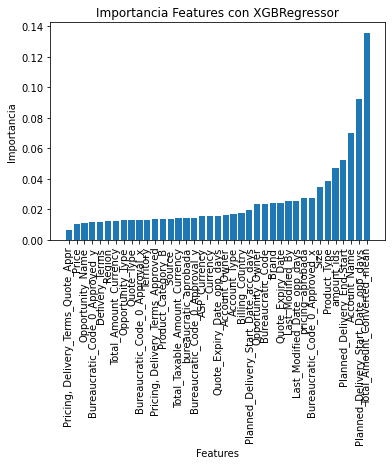

In [108]:
importancia_features_xgboost(trainX)

In [109]:
X_target_mean = X.merge(df_target_enc, on='Opportunity_ID')\
                 .merge(df_mean_enc, on='Opportunity_ID')
X_target_mean

,Opportunity_ID,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",pricing_aprobada,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,bureaucratic_aprobada,amount_ids,Total_Amount_Converted_mean,Last_Modified_Date_opp_days,...,Opportunity_Type_days,Opportunity_Type_amount,Account_Type_days,Account_Type_amount,Last_Modified_By_days,Last_Modified_By_amount,Opportunity_Owner_days,Opportunity_Owner_amount,Source _days,Source _amount
0,0,1,1,1,1,1,1,0,5.609362e+06,189,...,87.724601,5.946322e+05,88.799743,1.026040e+06,66.275000,7.587761e+05,63.555698,1.121455e+06,89.632200,1.120594e+06
1,1,0,0,1,0,0,1,0,5.130851e+04,39,...,87.724601,5.946322e+05,88.799743,1.026040e+06,123.318182,1.327410e+05,78.380952,2.675057e+05,89.632200,1.120594e+06
2,2,0,0,1,0,0,1,0,8.386560e+04,296,...,87.724601,5.946322e+05,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,98.953715,1.401714e+06
3,3,1,0,0,1,0,0,0,7.421882e+06,840,...,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
4,4,1,0,0,1,0,0,0,1.335719e+07,840,...,173.639855,5.421713e+06,154.362248,2.622246e+06,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12799,1,1,1,0,0,1,0,4.273404e+05,119,...,50.325591,4.849739e+05,88.799743,1.026040e+06,68.591667,1.088591e+06,85.040909,1.155765e+06,98.953715,1.401714e+06
11354,12800,1,0,0,0,0,1,1,1.066625e+07,311,...,87.724601,5.946322e+05,88.799743,1.026040e+06,91.037313,2.137204e+06,93.386179,1.482360e+06,86.633028,9.328264e+05
11355,12801,1,1,1,1,1,1,1,1.062819e+05,46,...,50.325591,4.849739e+05,56.705531,5.673916e+05,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06
11356,12802,1,1,1,1,1,1,0,2.346797e+06,48,...,50.325591,4.849739e+05,56.705531,5.673916e+05,135.872464,2.541861e+06,92.341890,2.164869e+06,71.402094,1.141496e+06


In [110]:
trainX = X_target_mean[X_target_mean['Opportunity_ID'].isin(train_ids)].copy()
trainX.drop('Opportunity_ID', axis=1, inplace=True)

testX = X_target_mean[X_target_mean['Opportunity_ID'].isin(test_ids)].copy()
testX.drop('Opportunity_ID', axis=1, inplace=True)

In [111]:
calcular_error_xgboost(trainX)

Log loss: 0.579253


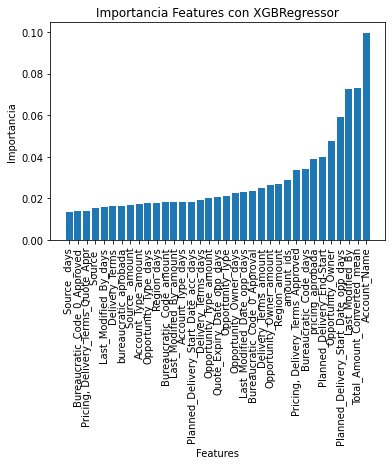

In [112]:
importancia_features_xgboost(trainX)

In [125]:

# Set the parameters by cross-validation
tuned_parameters = [{'colsample_bytree': [0.1,0.3,0.5],
                     'learning_rate': [0.1, 0.05],
                     'max_depth': [5,8,10,12],
                     'alpha': [5,10,15],
                     'n_estimators': [10,50],
                     'objective': ['binary:logistic'],
                     'eval_metric': ['logloss']}]

score = 'log_loss'
print('# Tuning hyper-parameters for XGBoost and Log loss')

X_train, X_test, y_train, y_test = \
    train_test_split(trainX, y, test_size=0.2, random_state=123)

xgb_reg = xgb.XGBRegressor()
clf = GridSearchCV(xgb_reg, tuned_parameters, cv=5)
clf.fit(X_train, y_train)

print("Best Params:")
print(clf.best_params_ )
print()
print('Best Score:')
print(clf.best_score_)

# Tuning hyper-parameters for XGBoost and Log loss
Best Params:
{'alpha': 5, 'colsample_bytree': 0.5, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 50, 'objective': 'binary:logistic'}

Best Score:
0.5649439166577478


In [160]:

# Set the parameters by cross-validation
tuned_parameters = [{'colsample_bytree': [0.1,0.3,0.5],
                     'learning_rate': [0.1],
                     'max_depth': [10,12],
                     'alpha': [5,10],
                     'n_estimators': [50],
                     'objective': ['binary:logistic'],
                     'eval_metric': ['logloss']}]

score = 'log_loss'
print('# Tuning hyper-parameters for XGBoost and Log loss')

xgb_reg = xgb.XGBRegressor()
clf = GridSearchCV(xgb_reg, tuned_parameters, cv=5)
clf.fit(trainX, y)

print("Best Params:")
print(clf.best_params_ )
print()
print('Best Score:')
print(clf.best_score_)

# Tuning hyper-parameters for XGBoost and Log loss
Best Params:
{'alpha': 5, 'colsample_bytree': 0.3, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 50, 'objective': 'binary:logistic'}

Best Score:
0.5242010224395282


In [162]:
# Calculo el error
kf = KFold(n_splits=5, shuffle=True)

errores = []
for train_index, test_index in kf.split(trainX):
    X_train, X_test = trainX.iloc[train_index], trainX.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xgb_reg = xgb.XGBRegressor(objective = 'binary:logistic', \
                           colsample_bytree = 0.3, \
                           learning_rate = 0.1, \
                           max_depth = 12, \
                           alpha = 5, \
                           n_estimators = 200, \
                           subsample=0.5,\
                           eval_metric='logloss')
    xgb_reg.fit(X_train, y_train)
    preds = xgb_reg.predict(X_test)

    loss = log_loss(y_test, preds)
    print(loss)
    errores.append(loss)
    
print("Log loss: %f" % (statistics.mean(errores)))

0.3032686622772221
0.30866522650395883
0.2747066806534741
0.32555653934190537
0.3212676464606279
Log loss: 0.306693


In [180]:
for s in [0.05,0.1,0.2,0.3,0.4]:
    xgb_reg = xgb.XGBRegressor(objective = 'binary:logistic', \
                               colsample_bytree = 0.3, \
                               learning_rate = 0.1, \
                               max_depth = 12, \
                               alpha = 5, \
                               n_estimators = 200, \
                               subsample=s,\
                               eval_metric='logloss')
    xgb_reg.fit(trainX, y)
    preds = xgb_reg.predict(trainX)

    loss = log_loss(y, preds)
    print('Subsample %0.2f: %f' % (s, loss))

Subsample 0.05: 0.342159
Subsample 0.10: 0.309381
Subsample 0.20: 0.265278
Subsample 0.30: 0.239711
Subsample 0.40: 0.218743


El error del test esta mas cercano a 0.30, asi que uso subsample 0.10

In [181]:
xgb_reg = xgb.XGBRegressor(objective = 'binary:logistic', \
                               colsample_bytree = 0.3, \
                               learning_rate = 0.1, \
                               max_depth = 12, \
                               alpha = 5, \
                               n_estimators = 200, \
                               subsample=s,\
                               eval_metric='logloss')

xgb_reg.fit(trainX, y)
preds = xgb_reg.predict(testX)

In [182]:
preds.shape

(1567,)

In [186]:
prediccion = pd.DataFrame({'Opportunity_ID':test_ids, 'Target':preds})
prediccion

,Opportunity_ID,Target
0,10689,0.929104
1,10690,0.659371
2,10691,0.715691
3,10692,0.598571
4,10693,0.886909
...,...,...
1562,12364,0.995817
1563,12365,0.502361
1564,12366,0.338974
1565,12367,0.607484


In [187]:
prediccion.to_csv('prediccion_xgboost_9', index=False)